In [1]:
import glob
import os
import json
import cv2
import matplotlib.pyplot as plt
import numpy as np

from math import sqrt
from itertools import product

import pandas as pd
import torch
import torch.utils.data as data
from torch.autograd import Function
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim

import time


In [2]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/SSD')
from data_augumentation import Compose,ConvertFromInts,ToAbsoluteCoords,PhotometricDistort,Expand,RandomSampleCrop,RandomMirror,ToPercentCoords,Resize,SubtractMeans

In [3]:
def make_datapath_list():
  train_image_list = sorted(glob.glob('/content/drive/My Drive/Colab Notebooks/SSD/images/train/*/*/*.jpg'))
  valid_image_list = sorted(glob.glob('/content/drive/My Drive/Colab Notebooks/SSD/images/valid/*/*/*.jpg'))
  train_annotation_list = sorted(glob.glob('/content/drive/My Drive/Colab Notebooks/SSD/annotations/train/*/*/*.txt'))
  valid_annotation_list = sorted(glob.glob('/content/drive/My Drive/Colab Notebooks/SSD/annotations/valid/*/*/*.txt'))
  return train_image_list, valid_image_list, train_annotation_list, valid_annotation_list

In [4]:
train_image_list, valid_image_list, train_annotation_list, valid_annotation_list = make_datapath_list()

In [5]:
class annotation_txt2list(object):
  def __init__(self, features):
    self.features = features
    self.genders = ['Male', 'Female']
    self.ages = ['under10', '10s', '20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s', 'over90']
    self.emotions = ['FEAR', 'SURPRISED', 'ANGRY', 'CONFUSED', 'HAPPY', 'DISGUSTED', 'CALM', 'SAD']

  def __call__(self, path):
    ret = []
    with open(path) as f:
      text = f.read()
      jsons = eval(text)['FaceDetails']
      for json in jsons:
        bBox = json['BoundingBox']
        xMin = bBox['Left']
        xMax = bBox['Left'] + bBox['Width']
        yMin = bBox['Top']
        yMax = bBox['Top'] + bBox['Height']
        age = (json[self.features[1]]['High'] + json[self.features[1]]['Low']) / 2
        ageRange = age // 10
        gender = self.genders.index(json[self.features[0]]['Value'])
        emotion = self.emotions.index(json[self.features[2]][0]['Type'])
        annotation = [xMin, yMin, xMax, yMax, gender, ageRange, emotion]
        ret += [annotation]
      return ret


In [6]:
selected_features = ['Gender','AgeRange', 'Emotions']
annotation_list = annotation_txt2list(selected_features)

In [7]:
class DataAugument():
  def __init__(self, input_size, color_mean):
    self.data_transform = {
        'train': Compose([
          ConvertFromInts(),
          ToAbsoluteCoords(),
          PhotometricDistort(),
          Expand(color_mean),
          RandomSampleCrop(),
          RandomMirror(),
          ToPercentCoords(),
          Resize(input_size),
          SubtractMeans(color_mean)
        ]),
        'val': Compose([
          ConvertFromInts(),
          Resize(input_size),
          SubtractMeans(color_mean)
        ])
    }
  def __call__(self, img, phase, boxes, labels):
    return self.data_transform[phase](img, boxes, labels)

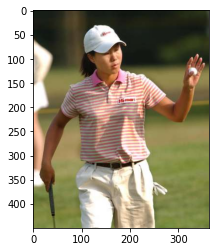

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


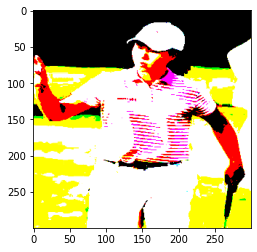

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


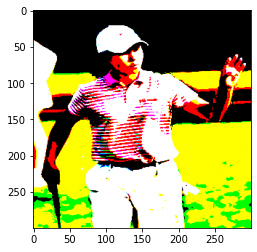

In [8]:
i = 0
image_file_path = train_image_list[i]
img = cv2.imread(image_file_path)
img.shape

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

anno_list = np.array(annotation_list(train_annotation_list[3]))

color_mean = (104, 117, 123)
input_size = 300
transform = DataAugument(input_size, color_mean)

phase = 'train'
img_transformed, boxes, labels = transform(img, phase, anno_list[:, :4], anno_list[:, 4:] )
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()

phase = 'val'
img_transformed, boxes, labels = transform(
    img, phase, anno_list[:, :4], anno_list[:, 4:] 
)
plt.imshow(cv2.cvtColor(img_transformed, cv2.COLOR_BGR2RGB))
plt.show()

In [9]:
class CreateDataset():
  def __init__(self, img_list, anno_list, phase, transform ,transform_anno):
    self.img_list = img_list
    self.anno_list = anno_list
    self.phase = phase
    self.transform = transform
    self.transform_anno  = transform_anno 
  def __len__(self):
    return len(self.img_list)
  def __getitem__(self, index):
    im, gt, h, w = self.pull_item(index)
    return im, gt
  def pull_item(self, index):
    imge_file_path = self.img_list[index]
    img = cv2.imread(image_file_path)
    height, width, channels = img.shape
    
    anno_file_path = self.anno_list[index]
    anno_list = np.array(self.transform_anno(anno_file_path))
    img, boxes, labels  = self.transform(img, self.phase, anno_list[:, :4], anno_list[:, 4:])

    img = torch.from_numpy(img[:, :, (2,1,0)]).permute(2,0,1)
    gt = np.hstack((boxes, labels))
    return img, gt, height, width



In [10]:
color_mean = (104, 117, 123)
input_size = 300
train_dataset = CreateDataset(img_list = train_image_list, anno_list = train_annotation_list, phase = 'train', 
                              transform = DataAugument(input_size, color_mean), transform_anno =annotation_txt2list(selected_features) )
val_dataset = CreateDataset(img_list = train_image_list, anno_list = train_annotation_list, phase = 'val', 
                              transform = DataAugument(input_size, color_mean), transform_anno =annotation_txt2list(selected_features) )

In [11]:
train_dataset.__getitem__(1)

(tensor([[[-112.4384, -112.4845, -112.4789,  ..., -112.0175, -112.0175,
           -112.0175],
          [-110.6504, -111.5542, -111.4438,  ..., -111.5644, -111.5644,
           -111.5644],
          [-108.4941, -108.7935, -108.7570,  ..., -108.4855, -108.4855,
           -108.4855],
          ...,
          [ 117.1540,  116.2819,  115.5770,  ...,  113.8777,  116.1552,
            117.1289],
          [ 117.5057,  116.5184,  115.9535,  ...,  116.3026,  115.9170,
            115.3531],
          [ 117.5057,  116.5184,  115.9984,  ...,  115.0206,  113.3459,
            113.1540]],
 
         [[-100.7406, -100.7406, -100.7406,  ..., -100.7873, -100.7873,
           -100.7873],
          [-100.6006, -100.5089, -100.5201,  ..., -101.4606, -101.4606,
           -101.4606],
          [ -99.7406,  -99.2384,  -99.2998,  ...,  -99.9739,  -99.9739,
            -99.9739],
          ...,
          [ 124.1288,  124.0258,  123.9426,  ...,  123.2110,  124.2594,
            124.2594],
          [ 124.1

In [12]:
def od_collate_fn(batch):
  targets = []
  imgs = []
  for sample in batch:
    imgs.append(sample[0])
    targets.append(torch.FloatTensor(sample[1]))
  imgs = torch.stack(imgs, dim = 0)
  return imgs, targets

In [13]:
def make_vgg():
  layers = []
  in_channels = 3
  cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'MC', 512, 512, 512, 'M', 512, 512, 512]
  for v in cfg:
    if v == 'M':
      layers += [nn.MaxPool2d(kernel_size = 2, stride = 2)]
    elif v == 'MC':
      layers += [nn.MaxPool2d(kernel_size =2, stride = 2, ceil_mode = True)]
    else:
      conv2d = nn.Conv2d(in_channels, v, kernel_size = 3, padding = 1)
      layers += [conv2d, nn.ReLU(inplace = True)]
      in_channels= v 
  pool5 = nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 1)
  conv6 = nn.Conv2d(512, 1024, kernel_size = 3, padding = 6, dilation = 6)
  conv7 =  nn.Conv2d(1024, 1024, kernel_size = 1)
  layers += [pool5, conv6, nn.ReLU(inplace = True), conv7, nn.ReLU(inplace = True)]
  return nn.ModuleList(layers)  
vgg_test = make_vgg()
print(vgg_test)

ModuleList(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (17): Conv2d(256, 512, kernel_siz

In [14]:
def make_extras():
    layers = []
    in_channels = 1024 
    cfg = [256, 512, 128, 256, 128, 256, 128, 256]

    layers += [nn.Conv2d(in_channels, cfg[0], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[0], cfg[1], kernel_size=(3), stride=2, padding=1)]
    layers += [nn.Conv2d(cfg[1], cfg[2], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[2], cfg[3], kernel_size=(3), stride=2, padding=1)]
    layers += [nn.Conv2d(cfg[3], cfg[4], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[4], cfg[5], kernel_size=(3))]
    layers += [nn.Conv2d(cfg[5], cfg[6], kernel_size=(1))]
    layers += [nn.Conv2d(cfg[6], cfg[7], kernel_size=(3))]
    return nn.ModuleList(layers)

extras_test = make_extras()
print(extras_test)

ModuleList(
  (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
  (1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (2): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))
  (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (6): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
)


In [15]:
def make_loc_conf(gender_classes = 3, age_classes = 12, emotion_classes = 9, bbox_aspect_num=[4, 6, 6, 6, 4, 4]):
    loc_layers = []
    gender_conf_layers = []
    age_conf_layers = []
    emotion_conf_layers = []

    loc_layers += [nn.Conv2d(512, bbox_aspect_num[0]
                             * 4, kernel_size=3, padding=1)]
    gender_conf_layers += [nn.Conv2d(512, bbox_aspect_num[0]
                              * gender_classes, kernel_size=3, padding=1)]
    age_conf_layers += [nn.Conv2d(512, bbox_aspect_num[0]
                              * age_classes, kernel_size=3, padding=1)]
    emotion_conf_layers += [nn.Conv2d(512, bbox_aspect_num[0]
                              * emotion_classes, kernel_size=3, padding=1)]

    loc_layers += [nn.Conv2d(1024, bbox_aspect_num[1]
                             * 4, kernel_size=3, padding=1)]
    gender_conf_layers += [nn.Conv2d(1024, bbox_aspect_num[1]
                              * gender_classes, kernel_size=3, padding=1)]
    age_conf_layers += [nn.Conv2d(1024, bbox_aspect_num[1]
                              * age_classes, kernel_size=3, padding=1)]
    emotion_conf_layers += [nn.Conv2d(1024, bbox_aspect_num[1]
                              * emotion_classes, kernel_size=3, padding=1)]

    loc_layers += [nn.Conv2d(512, bbox_aspect_num[2]
                             * 4, kernel_size=3, padding=1)]
    gender_conf_layers += [nn.Conv2d(512, bbox_aspect_num[2]
                              * gender_classes, kernel_size=3, padding=1)]
    age_conf_layers += [nn.Conv2d(512, bbox_aspect_num[2]
                              * age_classes, kernel_size=3, padding=1)]
    emotion_conf_layers += [nn.Conv2d(512, bbox_aspect_num[2]
                              * emotion_classes, kernel_size=3, padding=1)]

    loc_layers += [nn.Conv2d(256, bbox_aspect_num[3]
                             * 4, kernel_size=3, padding=1)]
    gender_conf_layers += [nn.Conv2d(256, bbox_aspect_num[3]
                              * gender_classes, kernel_size=3, padding=1)]
    age_conf_layers += [nn.Conv2d(256, bbox_aspect_num[3]
                              * age_classes, kernel_size=3, padding=1)]
    emotion_conf_layers += [nn.Conv2d(256, bbox_aspect_num[3]
                              * emotion_classes, kernel_size=3, padding=1)]

    loc_layers += [nn.Conv2d(256, bbox_aspect_num[4]
                             * 4, kernel_size=3, padding=1)]
    gender_conf_layers += [nn.Conv2d(256, bbox_aspect_num[4]
                              * gender_classes, kernel_size=3, padding=1)]
    age_conf_layers += [nn.Conv2d(256, bbox_aspect_num[4]
                              * age_classes, kernel_size=3, padding=1)]
    emotion_conf_layers += [nn.Conv2d(256, bbox_aspect_num[4]
                              * emotion_classes, kernel_size=3, padding=1)]

    loc_layers += [nn.Conv2d(256, bbox_aspect_num[5]
                             * 4, kernel_size=3, padding=1)]
    gender_conf_layers += [nn.Conv2d(256, bbox_aspect_num[5]
                              * gender_classes, kernel_size=3, padding=1)]
    age_conf_layers += [nn.Conv2d(256, bbox_aspect_num[5]
                              * age_classes, kernel_size=3, padding=1)]
    emotion_conf_layers += [nn.Conv2d(256, bbox_aspect_num[5]
                              * emotion_classes, kernel_size=3, padding=1)]

    return nn.ModuleList(loc_layers), nn.ModuleList(gender_conf_layers), nn.ModuleList(age_conf_layers), nn.ModuleList(emotion_conf_layers)

loc_test, gender_conf_test, age_conf_test, emotion_conf_test = make_loc_conf()
print(loc_test)
print(gender_conf_test)
print(age_conf_test)
print(emotion_conf_test)

ModuleList(
  (0): Conv2d(512, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(1024, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(512, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(256, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(256, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
ModuleList(
  (0): Conv2d(512, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(1024, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (2): Conv2d(512, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): Conv2d(256, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): Conv2d(256, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): Conv2d(256, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
ModuleList(
  (0): Conv2d(512, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [16]:
class L2Norm(nn.Module):
  def __init__(self, input_channels = 512, scale = 20):
    super(L2Norm, self).__init__()
    self.weight = nn.Parameter(torch.Tensor(input_channels))
    self.scale = scale
    self.reset_parameters()
    self.eps = 1e-10
  def reset_parameters(self):
    init.constant_(self.weight, self.scale)
  def forward(self, x):
    norm = x.pow(2).sum(dim = 1, keepdim = True).sqrt()+self.eps
    x = torch.div(x, norm)
    weights = self.weight.unsqueeze(0).unsqueeze(2).unsqueeze(3).expand_as(x)
    out = weights * x
    return out

In [17]:
class DBox(object):
  def __init__(self, cfg):
    super(DBox, self).__init__()
    self.image_size = cfg['input_size']
    self.feature_maps = cfg['feature_maps']
    self.num_priors = len(cfg['feature_maps'])
    self.steps = cfg['steps']
    self.min_sizes  = cfg['min_sizes']
    self.max_sizes = cfg['max_sizes']
    self.aspect_ratios = cfg['aspect_ratios']
  def make_dbox_list(self):
    mean = []
    for k, f in enumerate(self.feature_maps):
      for i, j in product(range(f), repeat = 2):
        f_k = self.image_size / self.steps[k]
        cx = (j + 0.5) / f_k
        cy = (i + 0.5) / f_k
        s_k = self.min_sizes[k]/self.image_size
        mean += [cx, cy, s_k, s_k]
        s_k_prime = sqrt(s_k * (self.max_sizes[k]/self.image_size))
        mean += [cx,  cy, s_k_prime, s_k_prime]

        for ar in self.aspect_ratios[k]:
          mean += [cx, cy, s_k*sqrt(ar), s_k/sqrt(ar)]
          mean += [cx, cy, s_k/sqrt(ar), s_k*sqrt(ar)]
    output = torch.Tensor(mean).view(-1, 4)
    output.clamp_(max= 1, min = 0)
    return output

In [18]:
ssd_cfg = {
    'gender_classes': 3,
    'age_classes': 12, 
    'emotion_classes': 9,
    'input_size': 300,  
    'bbox_aspect_num': [4, 6, 6, 6, 4, 4],  
    'feature_maps': [38, 19, 10, 5, 3, 1],  
    'steps': [8, 16, 32, 64, 100, 300],  
    'min_sizes': [30, 60, 111, 162, 213, 264],  
    'max_sizes': [60, 111, 162, 213, 264, 315],  
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
}

# DBox作成
dbox = DBox(ssd_cfg)
dbox_list = dbox.make_dbox_list()

# DBoxの出力を確認する
pd.DataFrame(dbox_list.numpy())

,0,1,2,3
0,0.013333,0.013333,0.100000,0.100000
1,0.013333,0.013333,0.141421,0.141421
2,0.013333,0.013333,0.141421,0.070711
3,0.013333,0.013333,0.070711,0.141421
4,0.040000,0.013333,0.100000,0.100000
...,...,...,...,...
8727,0.833333,0.833333,0.502046,1.000000
8728,0.500000,0.500000,0.880000,0.880000
8729,0.500000,0.500000,0.961249,0.961249
8730,0.500000,0.500000,1.000000,0.622254


In [19]:
class SSD(nn.Module):

    def __init__(self, phase, cfg):
        super(SSD, self).__init__()

        self.phase = phase  
        
        self.gender_classes = cfg["gender_classes"]  
        self.age_classes = cfg["age_classes"]  
        self.emotion_classes = cfg["emotion_classes"]  
        self.vgg = make_vgg()
        self.extras = make_extras()
        self.L2Norm = L2Norm()
        self.loc, self.gender_conf, self.age_conf, self.emotion_conf = make_loc_conf(
            cfg["gender_classes"], cfg["age_classes"], cfg["emotion_classes"], cfg["bbox_aspect_num"])

        dbox = DBox(cfg)
        self.dbox_list = dbox.make_dbox_list()
        if phase == 'inference':
            self.detect = Detect()

ssd_test = SSD(phase="train", cfg=ssd_cfg)
print(ssd_test)



SSD(
  (vgg): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [20]:
def decode(loc, dbox_list):
  boxes = torch.cat((dbox_list[:, :2] + loc[:, :2] * 0.1 * dbox_list[:, 2:], dbox_list[:, 2:]* torch.exp(loc[:, 2:] * 0.2)), dim = 1)
  boxes[:, :2] -= boxes[:, 2:] /2
  boxes[:, 2:] += boxes[:, :2]

  return boxes

In [21]:
def nm_supression(boxes, score, overlap = 0.45, top_k = 200):
  count = 0
  keep = scores.new(scores.size(0)).zero_().long()
  x1 = boxes[:, 0]
  y1 = boxes[:, 1]
  x2 = boxes[:, 2]
  y2 = boxes[:, 3]
  area = torch.mul(x2-x1, y2 - y1)

  tmp_x1 = boxes.new()
  tmp_x2 = boxes.new()
  tmp_y1 = boxes.new()
  tmp_y2 = boxes.new()
  tmp_w = boxes.new()
  tmp_h = boxes.new()

  v, idx = scores.sort(0)

  idx = idx[-top_k:]
  while idx.numel() > 0:
    i = idx[-1]
    keep[count] = i
    count += 1

    if idx.size(0) == 1:
      break

    idx = idx[:-1]

    torch.index_select(x1, 0, idx, out = tmp_x1)
    torch.index_select(y1, 0, idx, out = tmp_y1)
    torch.index_select(x2, 0, idx, out = tmp_x2)
    torch.index_select(y2, 0, idx, out = tmp_y2)

    tmp_x1 = torch.clamp(tmp_x1, min = x1[i])
    tmp_y1 = torch.clamp(tmp_y1, min = y1[i])
    tmp_x2 = torch.clamp(tmp_x2, max = x2[i])
    tmp_y2 = torch.clamp(tmp_y2, max = y2[i])

    tmp_w.resize_as_(tmp_x2)
    tmp_h.resize_as_(tmp_y2)

    tmp_w = tmp_x2 - tmp_x1
    tmp_h = tmp_y2 - tmp_y1

    tmp_w = torch.clamp(tmp_w, min = 0.0)
    tmp_h = torch.clamp(tmp_h, min = 0.0)
    inter = tmp_w * tmp_h 

    rem_areas = torch.index_select(area, 0, idx)
    union = (rem_areas - inter) + area[i]
    IoU = inter /union

    idx = idx[IoU.le(overlap)]
  return keep, count  

In [22]:
class Detect(Function):
  def __init__(self, conf_thresh = 0.01, top_k = 200, nms_thresh = 0.45):
    self.softmax = nn.SoftMax(dim = -1)
    self.conf_thresh = conf_thresh
    sel.top_k = top_k
    self.nms_thresh = nms_thresh
  def forward(self, loc_data, gender_conf_data, age_conf_data, emotion_conf_data, dbox_list):
    num_batch = loc_data.size(0)
    num_dbox = loc_data.size(1)
    gender_classes = gender_conf_data.size(2)
    age_classes = age_conf_data(2)
    emotion_classes = emotion_conf_data(2)


    conf_data = self.softmax(conf_data)
    output = torch.zeros(num_batch, gender_classes, age_classes, emotion_classes, self.top_k, 7)
    gender_conf_preds = gender_conf_data.transpose(2,1)
    age_conf_preds = age_conf_data.transpose(2,1)
    emotion_conf_preds = emotion_conf_data.transpose(2,1)
    for i in range(num_batch):
      dexoded_boxes = decode(loc_data[i], dbox_list )
      gender_conf_scores = gender_conf_preds[i].clone()
      age_conf_scores = age_conf_preds[i].clone()
      emotion_conf_scores = emotion_conf_preds[i].clone()

      for cl in range(1, gender_classes):
        c_mask = gender_conf_scores[cl].gt(self.conf_thresh)
        gender_scores = gender_conf_scores[cl][c_mask]
        age_scores = age_conf_scores[cl][c_mask]
        emotion_scores = emotion_conf_scores[cl][c_mask]
        if scores.nelement() == 0:
          continue
        l_mask = c_mask.unsqueeze(1).expand_as(decoded_boxes)

        boxes = decoded_boxes[l_mask].view(-1, 4)
        ids, count = nm_supression(boxes, scores, self.nms_thresh, self,top_k)
        output[i, cl, cl, cl, :count] = torch.cat((gender_scores[ids[:count]].unsqueeze(1),age_scores[ids[:count]].unsqueeze(1), emotion_scores[ids[:count]].unsqueeze(1), boxes[ids[:count]]), 1)

    # ここきちんと確認する
    print("ここ確認")
    print(output.size())
    return output

In [23]:
class SSD(nn.Module):
  def __init__(self, phase, cfg):
    super(SSD, self).__init__()

    self.phase = phase
    self.gender_classes = cfg["gender_classes"]
    self.age_classes = cfg["age_classes"]
    self.emotion_classes = cfg["emotion_classes"]
    self.vgg = make_vgg()
    self.extras = make_extras()
    self.L2Norm = L2Norm()
    self.loc, self.gender_conf, self.age_conf, self.emotion_conf = make_loc_conf(cfg["gender_classes"], cfg["age_classes"], cfg["emotion_classes"], cfg["bbox_aspect_num"])
    dbox = DBox(cfg)
    self.dbox_list = dbox.make_dbox_list()

    if phase == "inference":
      self.detect = Detect()
  def forward(self, x):
    sources = list()
    loc = list()
    gender_conf = list()
    age_conf = list()
    emotion_conf = list()

    for k in range(23):
      x = self.vgg[k](x)
    source1 = self.L2Norm(x)
    sources.append(source1)

    for k in range(23, len(self.vgg)):
      x  = self.vgg[k](x)
    sources.append(x)
    for k, v in enumerate(self.extras):
      x = F.relu(v(x), inplace = True)
      if k % 2 == 1:
        sources.append(x)
    for (x, l, gc, ac, ec) in zip(sources, self.loc, self.gender_conf, self.age_conf, self.emotion_conf):
      
      loc.append(l(x).permute(0,2,3,1).contiguous())
      gender_conf.append(gc(x).permute(0,2,3,1).contiguous())
      age_conf.append(ac(x).permute(0,2,3,1).contiguous())
      emotion_conf.append(ec(x).permute(0,2,3,1).contiguous())

    loc = torch.cat([o.view(o.size(0), -1) for o in loc], 1)
    gender_conf = torch.cat([o.view(o.size(0), -1) for o in gender_conf], 1)
    age_conf = torch.cat([o.view(o.size(0), -1) for o in age_conf], 1)
    emotion_conf = torch.cat([o.view(o.size(0), -1) for o in emotion_conf], 1)

    loc = loc.view(loc.size(0), -1, 4)
    gender_conf = gender_conf.view(gender_conf.size(0), -1, self.gender_classes)
    age_conf = age_conf.view(age_conf.size(0), -1, self.age_classes)
    emotion_conf = emotion_conf.view(emotion_conf.size(0), -1, self.emotion_classes)

    output = (loc, gender_conf, age_conf, emotion_conf, self.dbox_list)

    if self.phase == "interference":
      return self.detect(output[0], output[1], output[2], output[3], output[4])
    else:
      return output


In [24]:
"""
https://github.com/amdegroot/ssd.pytorch
のbox_utils.pyより使用
関数matchを行うファイル
本章の実装はGitHub：amdegroot/ssd.pytorch [4] を参考にしています。
MIT License
Copyright (c) 2017 Max deGroot, Ellis Brown
"""


import torch

def point_form(boxes):
    """ Convert prior_boxes to (xmin, ymin, xmax, ymax)
    representation for comparison to point form ground truth data.
    Args:
        boxes: (tensor) center-size default boxes from priorbox layers.
    Return:
        boxes: (tensor) Converted xmin, ymin, xmax, ymax form of boxes.
    """
    return torch.cat((boxes[:, :2] - boxes[:, 2:]/2,     # xmin, ymin
                     boxes[:, :2] + boxes[:, 2:]/2), 1)  # xmax, ymax


def center_size(boxes):
    """ Convert prior_boxes to (cx, cy, w, h)
    representation for comparison to center-size form ground truth data.
    Args:
        boxes: (tensor) point_form boxes
    Return:
        boxes: (tensor) Converted xmin, ymin, xmax, ymax form of boxes.
    """
    return torch.cat((boxes[:, 2:] + boxes[:, :2])/2,  # cx, cy
                     boxes[:, 2:] - boxes[:, :2], 1)  # w, h


def intersect(box_a, box_b):
    """ We resize both tensors to [A,B,2] without new malloc:
    [A,2] -> [A,1,2] -> [A,B,2]
    [B,2] -> [1,B,2] -> [A,B,2]
    Then we compute the area of intersect between box_a and box_b.
    Args:
      box_a: (tensor) bounding boxes, Shape: [A,4].
      box_b: (tensor) bounding boxes, Shape: [B,4].
    Return:
      (tensor) intersection area, Shape: [A,B].
    """
    A = box_a.size(0)
    B = box_b.size(0)
    max_xy = torch.min(box_a[:, 2:].unsqueeze(1).expand(A, B, 2),
                       box_b[:, 2:].unsqueeze(0).expand(A, B, 2))
    min_xy = torch.max(box_a[:, :2].unsqueeze(1).expand(A, B, 2),
                       box_b[:, :2].unsqueeze(0).expand(A, B, 2))
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]


def jaccard(box_a, box_b):
    """Compute the jaccard overlap of two sets of boxes.  The jaccard overlap
    is simply the intersection over union of two boxes.  Here we operate on
    ground truth boxes and default boxes.
    E.g.:
        A ∩ B / A ∪ B = A ∩ B / (area(A) + area(B) - A ∩ B)
    Args:
        box_a: (tensor) Ground truth bounding boxes, Shape: [num_objects,4]
        box_b: (tensor) Prior boxes from priorbox layers, Shape: [num_priors,4]
    Return:
        jaccard overlap: (tensor) Shape: [box_a.size(0), box_b.size(0)]
    """
    inter = intersect(box_a, box_b)
    area_a = ((box_a[:, 2]-box_a[:, 0]) *
              (box_a[:, 3]-box_a[:, 1])).unsqueeze(1).expand_as(inter)  # [A,B]
    area_b = ((box_b[:, 2]-box_b[:, 0]) *
              (box_b[:, 3]-box_b[:, 1])).unsqueeze(0).expand_as(inter)  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]


def match(threshold, truths, priors, variances, labels, loc_t, conf_t, idx):
    """Match each prior box with the ground truth box of the highest jaccard
    overlap, encode the bounding boxes, then return the matched indices
    corresponding to both confidence and location preds.
    Args:
        threshold: (float) The overlap threshold used when mathing boxes.
        truths: (tensor) Ground truth boxes, Shape: [num_obj, num_priors].
        priors: (tensor) Prior boxes from priorbox layers, Shape: [n_priors,4].
        variances: (tensor) Variances corresponding to each prior coord,
            Shape: [num_priors, 4].
        labels: (tensor) All the class labels for the image, Shape: [num_obj].
        loc_t: (tensor) Tensor to be filled w/ endcoded location targets.
        conf_t: (tensor) Tensor to be filled w/ matched indices for conf preds.
        idx: (int) current batch index
    Return:
        The matched indices corresponding to 1)location and 2)confidence preds.
    """
    # print('============match関数==============')
    # print('labelsは、、、')
    # print(labels)
    # print(labels.size())
    # jaccard index
    overlaps = jaccard(
        truths,
        point_form(priors)
    )
    # print('overlapsって何')
    # print(overlaps)
    # (Bipartite Matching)
    # [1,num_objects] best prior for each ground truth
    best_prior_overlap, best_prior_idx = overlaps.max(1, keepdim=True)
    # [1,num_priors] best ground truth for each prior
    best_truth_overlap, best_truth_idx = overlaps.max(0, keepdim=True)
    best_truth_idx.squeeze_(0)
    best_truth_overlap.squeeze_(0)
    best_prior_idx.squeeze_(1)
    best_prior_overlap.squeeze_(1)
    best_truth_overlap.index_fill_(0, best_prior_idx, 2)  # ensure best prior
    # TODO refactor: index  best_prior_idx with long tensor
    # ensure every gt matches with its prior of max overlap

    for j in range(best_prior_idx.size(0)):
        best_truth_idx[best_prior_idx[j]] = j
    matches = truths[best_truth_idx]          # Shape: [num_priors,4]
    # print('best_truth_idxは')
    # print(best_truth_idx)
    # print(best_truth_idx.size())
    # print("labelsは")
    # print(labels[best_truth_idx])
    # print(labels[best_truth_idx].size())
    conf = labels[best_truth_idx] + 1        # Shape: [num_priors]
    # print('confは')
    # print(conf)
    # print(conf.size())
    conf[best_truth_overlap < threshold] = 0  # label as background
    loc = encode(matches, priors, variances)
    loc_t[idx] = loc    # [num_priors,4] encoded offsets to learn
    # print(conf)
    conf_t[idx] = conf  # [num_priors] top class label for each prior


def encode(matched, priors, variances):
    """Encode the variances from the priorbox layers into the ground truth boxes
    we have matched (based on jaccard overlap) with the prior boxes.
    Args:
        matched: (tensor) Coords of ground truth for each prior in point-form
            Shape: [num_priors, 4].
        priors: (tensor) Prior boxes in center-offset form
            Shape: [num_priors,4].
        variances: (list[float]) Variances of priorboxes
    Return:
        encoded boxes (tensor), Shape: [num_priors, 4]
    """

    # dist b/t match center and prior's center
    g_cxcy = (matched[:, :2] + matched[:, 2:])/2 - priors[:, :2]
    # encode variance
    g_cxcy /= (variances[0] * priors[:, 2:])
    # match wh / prior wh
    g_wh = (matched[:, 2:] - matched[:, :2]) / priors[:, 2:]
    g_wh = torch.log(g_wh) / variances[1]
    # return target for smooth_l1_loss
    return torch.cat([g_cxcy, g_wh], 1)  # [num_priors,4]

In [25]:
class MultiBoxLoss(nn.Module):
  def __init__(self, jaccard_thresh = 0.5, neg_pos = 3, device = 'cpu'):
    super(MultiBoxLoss, self).__init__()
    self.jaccard_thresh = jaccard_thresh
    self.negpos_ratio = neg_pos
    self.device = device
  def forward(self, predictions, targets):
    loc_data, gender_conf_data, age_conf_data, emotion_conf_data, dbox_list = predictions
    num_batch = loc_data.size(0)
    num_dbox = loc_data.size(1)
    gender_classes = gender_conf_data.size(2)
    age_classes = age_conf_data.size(2)
    emotion_classes = emotion_conf_data.size(2)
    # print('ロス関数のnum_batach')
    # print(num_batch)
    # print('ロス関数のnum_dbox')
    # print(num_dbox)
    # print('ロス関数のgender_class')
    # print(gender_classes)
    # print('ロス関数のage_classes')
    # print(age_classes)
    # print('ロス関数のemotion_classes')
    # print(emotion_classes)
    conf_t_label = torch.LongTensor(num_batch, num_dbox, 3).to(self.device)
    loc_t = torch.Tensor(num_batch, num_dbox, 4).to(self.device)

    for idx in range(num_batch):
      truths = targets[idx][:, :-3].to(self.device)
      # print('ロス関数のバッチごとのbox情報は')
      # print(truths)
      labels = targets[idx][:, -3:].to(self.device)
      # print('ロス関数のバッチごとのlabel情報は')
      # print(labels) 
      dbox = dbox_list.to(self.device)

      variance = [0.1, 0.2]
      match(self.jaccard_thresh, truths, dbox, variance, labels, loc_t, conf_t_label, idx)
    # print(truths)
    # print('match後のリストは')
    # print(conf_t_label)
     
    print(conf_t_label.size())
    # for i in range(8732):
    #   print(conf_t_label[0, i, :])
    pos_mask = conf_t_label[:, :, 0] > 0
    pos_idx = pos_mask.unsqueeze(pos_mask.dim()).expand_as(loc_data)

    loc_p = loc_data[pos_idx].view(-1, 4)
    loc_t = loc_t[pos_idx].view(-1, 4)
    # print('loc_pは')
    # print(loc_p)
    # print('loc_tは')
    # print(loc_t)


    loss_l = F.smooth_l1_loss(loc_p, loc_t, reduction = "sum")
    # print('ボックスのlossは')
    # print(loss_l)

    batch_gender_conf = gender_conf_data.view(-1, gender_classes)
    batch_age_conf = age_conf_data.view(-1, age_classes)
    batch_emotion_conf = emotion_conf_data.view(-1, emotion_classes)

    gender_loss_c = F.cross_entropy(batch_gender_conf, conf_t_label[:,:, 0].view(-1), reduction = "none")
    age_loss_c = F.cross_entropy(batch_age_conf, conf_t_label[:, :, 1].view(-1), reduction = "none")
    emotion_loss_c = F.cross_entropy(batch_emotion_conf, conf_t_label[:, :, 2].view(-1), reduction = "none" )
    # print('genderの予想は')
    # print(batch_gender_conf)
    # print('genderの正解は')
    # print(conf_t_label[:,:, 0].view(-1))
    # print('genderの損失は')
    # print(gender_loss_c)
    # print('ageの予想は')
    # print(batch_age_conf)
    # print('ageの正解は')
    # print(conf_t_label[:,:, 1].view(-1))
    # print('ageの損失は')
    # print(age_loss_c)
    # print('emotionの予想は')
    # print(batch_emotion_conf)
    # print('emotionの正解は')
    # print(conf_t_label[:,:, 2].view(-1))
    # print('emotionの損失は')
    # print(emotion_loss_c)

    num_pos = pos_mask.long().sum(1, keepdim = True)
    gender_loss_c = gender_loss_c.view(num_batch, -1)
    age_loss_c = age_loss_c.view(num_batch, -1)
    emotion_loss_c = emotion_loss_c.view(num_batch, -1)
    

    gender_loss_c[pos_mask] = 0
    age_loss_c[pos_mask] = 0
    emotion_loss_c[pos_mask] = 0

    _,  gender_loss_idx = gender_loss_c.sort(1, descending = True)
    _,  age_loss_idx = age_loss_c.sort(1, descending = True)
    _, emotion_loss_idx = emotion_loss_c.sort(1, descending = True)

    _, gender_idx_rank = gender_loss_idx.sort(1)
    _, age_idx_rank = age_loss_idx.sort(1)
    _, emotion_idx_rank = emotion_loss_idx.sort(1)

    num_neg = torch.clamp(num_pos * self.negpos_ratio, max = num_dbox)

    neg_mask = gender_idx_rank < (num_neg).expand_as(gender_idx_rank)
    gender_pos_idx_mask = pos_mask.unsqueeze(2).expand_as(gender_conf_data)
    gender_neg_idx_mask = neg_mask.unsqueeze(2).expand_as(gender_conf_data)
    age_pos_idx_mask = pos_mask.unsqueeze(2).expand_as(age_conf_data)
    age_neg_idx_mask = neg_mask.unsqueeze(2).expand_as(age_conf_data)
    emotion_pos_idx_mask = pos_mask.unsqueeze(2).expand_as(emotion_conf_data)
    emotion_neg_idx_mask = neg_mask.unsqueeze(2).expand_as(emotion_conf_data)


    gender_conf_hum = gender_conf_data[(gender_pos_idx_mask + gender_neg_idx_mask).gt(0)].view(-1, gender_classes)
    age_conf_hum = age_conf_data[(age_pos_idx_mask + age_neg_idx_mask).gt(0)].view(-1, age_classes)
    emotion_conf_hum = emotion_conf_data[(emotion_pos_idx_mask + emotion_neg_idx_mask).gt(0)].view(-1, emotion_classes)

    conf_t_label_hum = conf_t_label[(pos_mask+neg_mask).gt(0)]

    gender_loss_c = F.cross_entropy(gender_conf_hum, conf_t_label_hum[:, 0], reduction= "sum")
    age_loss_c = F.cross_entropy(age_conf_hum, conf_t_label_hum[:, 1], reduction= "sum")
    emotion_loss_c = F.cross_entropy(emotion_conf_hum, conf_t_label_hum[:, 2], reduction= "sum")



    N = num_pos.sum()
    loss_l /= N
    gender_loss_c /= N
    age_loss_c /= N
    emotion_loss_c /= N
    # print('最終的なgenderのlossは')
    # print(gender_loss_c)
    # print('最終的なageのlossは')
    # print(age_loss_c)
    # print('最終的なemotionのlossは')
    # print(emotion_loss_c)

    return loss_l, gender_loss_c, age_loss_c, emotion_loss_c

    




In [26]:
batch_size = 32

train_data_loader = data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True, collate_fn = od_collate_fn)
val_data_loader = data.DataLoader(val_dataset, batch_size = batch_size, shuffle = False, collate_fn = od_collate_fn)

dataloaders_dict = {'train': train_data_loader, "val": val_data_loader}

In [27]:
import urllib.request
url = "https://s3.amazonaws.com/amdegroot-models/vgg16_reducedfc.pth"
target_path = os.path.join('..', "vgg16_reducedfc.pth") 

if not os.path.exists(target_path):
    urllib.request.urlretrieve(url, target_path)

In [28]:
ssd = SSD(phase = "train", cfg=ssd_cfg)

vgg_weights = torch.load('../vgg16_reducedfc.pth')
ssd.vgg.load_state_dict(vgg_weights)

def weights_init(m):
  if isinstance(m, nn.Conv2d):
    init.kaiming_normal_(m.weight.data)
    if m.bias is not None:
      nn.init.constant_(m.bias, 0.0)
ssd.extras.apply(weights_init)
ssd.loc.apply(weights_init)
ssd.gender_conf.apply(weights_init)
ssd.age_conf.apply(weights_init)
ssd.emotion_conf.apply(weights_init)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print("done")

cuda:0
done


In [29]:
criterion = MultiBoxLoss(jaccard_thresh = 0.5, neg_pos = 3, device = device)
optimizer = optim.SGD(ssd.parameters(), lr = 1e-3, momentum = 0.9, weight_decay=5e-4)

In [30]:
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(device)
  net.to(device)

  torch.backends.cudnn.benchmark = True
  iteration = 1
  epoch_train_loss = 0.0
  epoch_val_loss = 0.0

  logs = []

  for epoch in range(num_epochs + 1):
    t_epoch_start = time.time()
    t_iter_start = time.time()

    print('-----------------------------------')
    print('Epoch {}/{}'.format(epoch+1, num_epochs))

    for phase in ['train', 'val']:
      if phase == 'train':
        net.train()
        print("(train)")

      else:
        if ((epoch + 1) % 10 == 0):
          net.eval()
          print('--------------------------------------')
          print('(val)')
        else:
          continue
      print(len(dataloaders_dict[phase]))
      for images, targets in dataloaders_dict[phase]:
          images = images.to(device)
          targets = [ann.to(device) for ann in targets]
          optimizer.zero_grad()
          with torch.set_grad_enabled(phase == 'train'):
            outputs = net(images)
            loss_l, gender_loss_c, age_loss_c, emotion_loss_c = criterion(outputs, targets)
            # print("loss_l")
            # print(loss_l)
            # print('gender_loss_c')
            # print(gender_loss_c)
            # print('age_loss_c')
            # print(age_loss_c)
            # print('emotion_loss_c')
            # print(emotion_loss_c)

            loss = loss_l + gender_loss_c + age_loss_c + emotion_loss_c
            if phase == 'train':
              loss.backward()
              # print('optimizer前')
              # print(net.parameters())
              nn.utils.clip_grad_value_(net.parameters(), clip_value =2.0)
              optimizer.step()
              # print('optimizer後')
              # print(net.parameters())

              if (iteration % 10 == 0):
                t_iter_finish = time.time()
                duration = t_iter_finish - t_iter_start
                print('イテレーション {} || Loss: {:.4f} || 10iter: {:.4f} sec.'.format(iteration, loss.item(), duration))
                t_iter_start = time.time()
                epoch_train_loss += loss.item()
                print("lossの合計は")
                print(epoch_train_loss)
              iteration += 1
            else: 
              epoch_val_loss += loss.item()
    t_epoch_finish = time.time()
    print('-------------')
    print('epoch {} || Epoch_TRAIN_Loss:{:.4f} ||Epoch_VAL_Loss:{:.4f}'.format(
            epoch+1, epoch_train_loss, epoch_val_loss))
    print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
    t_epoch_start = time.time()

    # ログを保存
    log_epoch = {'epoch': epoch+1,
                 'train_loss': epoch_train_loss, 'val_loss': epoch_val_loss}
    logs.append(log_epoch)
    df = pd.DataFrame(logs)
    df.to_csv("log_output.csv")

    epoch_train_loss = 0.0  # epochの損失和
    epoch_val_loss = 0.0  # epochの損失和

    # ネットワークを保存する
    if ((epoch+1) % 10 == 0):
        torch.save(net.state_dict(), 'weights/ssd300_' +
                       str(epoch+1) + '.pth')

    

In [ ]:
num_epochs = 50

train_model(ssd, dataloaders_dict, criterion, optimizer, num_epochs = num_epochs)

cuda:0
-----------------------------------
Epoch 1/50
(train)
176
torch.Size([32, 8732, 3])
torch.Size([32, 8732, 3])
torch.Size([32, 8732, 3])
torch.Size([32, 8732, 3])
torch.Size([32, 8732, 3])
torch.Size([32, 8732, 3])
torch.Size([32, 8732, 3])
torch.Size([32, 8732, 3])
torch.Size([32, 8732, 3])
torch.Size([32, 8732, 3])
イテレーション 10 || Loss: 31.2162 || 10iter: 145.9695 sec.
lossの合計は
31.21624755859375
torch.Size([32, 8732, 3])
torch.Size([32, 8732, 3])
torch.Size([32, 8732, 3])
torch.Size([32, 8732, 3])
torch.Size([32, 8732, 3])
torch.Size([32, 8732, 3])
torch.Size([32, 8732, 3])
torch.Size([32, 8732, 3])
torch.Size([32, 8732, 3])
torch.Size([32, 8732, 3])
イテレーション 20 || Loss: 28.2044 || 10iter: 125.0898 sec.
lossの合計は
59.42064666748047
torch.Size([32, 8732, 3])
torch.Size([32, 8732, 3])
torch.Size([32, 8732, 3])
torch.Size([32, 8732, 3])
torch.Size([32, 8732, 3])
torch.Size([32, 8732, 3])
torch.Size([32, 8732, 3])
torch.Size([32, 8732, 3])
torch.Size([32, 8732, 3])
torch.Size([32, 8732

In [ ]:
np.set_printoptions(threshold=np.inf)